In [ ]:
!pip install keras
from keras.models import Sequential

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style='darkgrid')
import matplotlib.pyplot as plt
import copy
import os
import torch
from PIL import Image
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
from torchvision import utils
from torchvision.datasets import ImageFolder
from torchsummary import summary
import torch.nn.functional as F
from sklearn.metrics import classification_report
import itertools
from tqdm.notebook import trange, tqdm
from torch import optim
import warnings
warnings.filterwarnings('ignore')

#import libarary yang dibutuhkan

In [ ]:
transform = transforms.Compose(
    [
        transforms.Resize((255,255)), #menyamakan ukuran gambar
        transforms.RandomHorizontalFlip(p=0.5), #memberikan flip horizon dengan prob 50%
        transforms.RandomVerticalFlip(p=0.5), #vertical dengan prob 50%
        transforms.RandomRotation(30), #random rotate 30 derajat
        transforms.ToTensor(),#Mengubah gambar dari format PIL atau numpy array menjadi tensor PyTorch.
        transforms.Normalize(mean = [0.485, 0.456, 0.406],std = [0.229, 0.224, 0.225]) #normalisasi RGB dengan standar deviasi
   ]
)

#transform image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


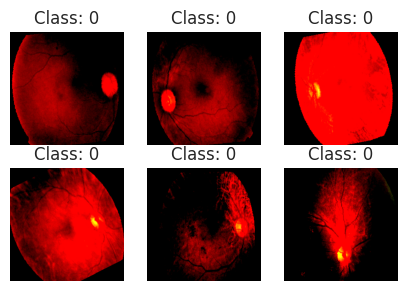

In [ ]:
folder_path = "/content/drive/MyDrive/Colab Notebooks/Datasets/Diabetic Rethinopaty/colored_images"  # Replace with your actual folder path
dataset = datasets.ImageFolder(folder_path, transform=transform)  # Assuming 'transform' is defined as in your previous code

plt.figure(figsize=(5, 5))
for i in range(6):  # Display 6 images
    image, label = dataset[i]
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.permute(1, 2, 0))  # Transpose the image to (height, width, channels)
    plt.title(f"Class: {label}")
    plt.axis("off")

plt.show()

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split
from PIL import Image

In [ ]:
# Path to your main image directory containing class folders
data_dir = "/content/drive/MyDrive/Colab Notebooks/Datasets/Diabetic Rethinopaty/colored_images"

# Desired ratio of test data (e.g., 0.2 for 20%)
test_size = 0.2

# Path for the output train and test directories
output_dir = "/content/drive/MyDrive/Colab Notebooks/Datasets/Diabetic Rethinopaty/split_data"

train_dir = os.path.join(output_dir, "train")
test_dir = os.path.join(output_dir, "test")

In [ ]:
train_folder = '/content/drive/MyDrive/Colab Notebooks/Datasets/Diabetic Rethinopaty/split_data/train'
test_folder = '/content/drive/MyDrive/Colab Notebooks/Datasets/Diabetic Rethinopaty/split_data/test'

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [ ]:
for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    if os.path.isdir(class_dir):
        images = os.listdir(class_dir)
        train_images, test_images = train_test_split(images, test_size=test_size, random_state=42)

        # Create class subdirectories in train and test directories
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

        # Move images to respective train and test directories
        for image in train_images:
            src = os.path.join(class_dir, image)
            dst = os.path.join(train_dir, class_name, image)
            shutil.copy(src, dst)

        for image in test_images:
            src = os.path.join(class_dir, image)
            dst = os.path.join(test_dir, class_name, image)
            shutil.copy(src, dst)

In [ ]:
num_train_images = 0
num_test_images = 0

for class_name in os.listdir(train_dir):
    class_dir = os.path.join(train_dir, class_name)
    if os.path.isdir(class_dir):
        num_train_images += len(os.listdir(class_dir))

for class_name in os.listdir(test_dir):
    class_dir = os.path.join(test_dir, class_name)
    if os.path.isdir(class_dir):
        num_test_images += len(os.listdir(class_dir))

print("Number of training images:", num_train_images)
print("Number of testing images:", num_test_images)

Number of training images: 2936
Number of testing images: 736


**EKSTARAKSI FITUR CNN**

In [ ]:
from tensorflow import keras
from keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense
from keras.layers import TimeDistributed # TimeDistributed has been moved to keras.layers
from keras.models import Sequential

In [ ]:
def create_cnn():
    cnn = Sequential()
    cnn.add(Conv2D(64, (5, 5), activation='relu', input_shape=(64, 64, 3)))  # Input gambar 64x64 dengan 3 channel (RGB)
    cnn.add(MaxPooling2D(pool_size=(3, 3)))
    cnn.add(Conv2D(128, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2, 2)))
    cnn.add(Conv2D(256, (3, 3), activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2, 2)))
    cnn.add(Flatten())
    return cnn

**HYBRID MODEL**

In [ ]:
def create_hybrid_model():
    model = Sequential()

    # CNN diterapkan untuk setiap frame dari urutan gambar menggunakan TimeDistributed
    cnn = create_cnn()
    model.add(TimeDistributed(cnn, input_shape=(10, 64, 64, 3)))  # 10 frames, ukuran 64x64, 3 channel warna

    # LSTM untuk memproses fitur temporal dari frame-frame yang dihasilkan CNN
    model.add(LSTM(64, activation='tanh'))  # 64 units LSTM

    # Dense layer untuk klasifikasi biner
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # Output untuk klasifikasi biner

    # Kompilasi model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss') # Changed the extension to .keras

In [ ]:
X_train = np.random.rand(100, 10, 64, 64, 3)  # 100 sequences, 10 frames each
y_train = np.random.randint(2, size=100)  # 100 binary labels

X_test = np.random.rand(20, 10, 64, 64, 3)  # 20 validation sequences
y_test = np.random.randint(2, size=64)  # 20 binary validation labels

model = create_hybrid_model();

model.fit(X_train, y_train, epochs=50, batch_size=64,  callbacks=[early_stopping, model_checkpoint])

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - accuracy: 0.4702 - loss: 0.6712
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.6796 - loss: 0.6780
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.6640 - loss: 0.6392
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - accuracy: 0.6483 - loss: 0.6600
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.6327 - loss: 0.6545
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 4s/step - accuracy: 0.6640 - loss: 0.6401
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.6692 - loss: 0.6400
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - accuracy: 0.6535 - loss: 0.6520
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - accuracy: 0.6483 - loss: 0.6513
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.6640 - loss: 0.6389
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.6379 - loss: 0.6558
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.6535 - loss: 0.6448
Epoch 13/50
2

In [ ]:
# Generate dummy test data: 20 samples of 10 frames
X_test = np.random.rand(20, 10, 64, 64, 3)
y_test = np.random.randint(2, size=20)

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.4500 - loss: 0.7045
Test Accuracy: 0.44999998807907104


In [ ]:
# Predict on new data
predictions = model.predict(X_test)
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
[[0.54220265]
 [0.5409615 ]
 [0.5424233 ]
 [0.5407481 ]
 [0.5425209 ]
 [0.53969646]
 [0.54258597]
 [0.540296  ]
 [0.5412154 ]
 [0.5421375 ]
 [0.54201466]
 [0.54116046]
 [0.54194593]
 [0.54083836]
 [0.5420297 ]
 [0.54157627]
 [0.5420021 ]
 [0.542313  ]
 [0.54241395]
 [0.5413588 ]]


In [ ]:
model = create_hybrid_model()

In [ ]:
model.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_8 (TimeDistributed) │ (None, 10, 2304)            │         373,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 64)                  │         606,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 984,577 (3.76 MB)

 Trainable params: 984,577 (3.76 MB)

 Non-trainable params: 0 (0.00 B)

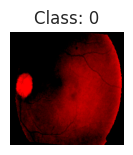

In [ ]:
folder_path = "/content/drive/MyDrive/Colab Notebooks/Datasets/Diabetic Rethinopaty/split_data/test"  # Replace with your actual folder path

plt.figure(figsize=(5, 5))
for i in range(1):  # Display 6 images
    image, label = dataset[i]
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.permute(1, 2, 0))  # Transpose the image to (height, width, channels)
    plt.title(f"Class: {label}")
    plt.axis("off")

plt.show()